# Previsão de Preços de Imóveis

## Desafio

O time comercial precisa da nossa ajuda para decidir, assertivamente, se compram ou não imóveis que entraram no sistema. Para isso eles querem saber qual o preço ideal desses imóveis.

## Objetivo

O objetivo é desenvolver um modelo de regressão que seja capaz de precificar os imóveis ofertados pelos clientes. Porém, apenas o modelo não é o suficiente. Queremos entender o porquê dele ser bom e como mostrar para o comercial que eles podem confiar nele para tomar decisões.

### Alguns pontos importantes para o desafio:

* Precificação dos imóveis
* Composição do preço
* Por que devemos confiar nele?

In [1]:
#Carregando as bibliotecas:

# para tratamento dos dados
import pandas as pd 
import numpy as np

#visualização dos dados
from matplotlib import pyplot as plt
import seaborn as sns
color = "#dd2176" #cor padrão para os graficos

#transformações e distribuições de probabilidade
from scipy.stats import boxcox
import scipy.stats as stats

#para pre-processamento dos dados
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder

#feature selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression

#redução de dimensionalidade
from sklearn.decomposition import PCA 

#divisão dos dados em treino e teste, validação cruzada e tuning de modelo
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_validate,KFold

#métricas do modelo
from sklearn.metrics import mean_squared_error, r2_score

#algoritmos de regressão
from sklearn.linear_model import LinearRegression,Lasso,LassoLars,ElasticNet,Ridge,GammaRegressor,PassiveAggressiveRegressor,BayesianRidge,HuberRegressor
from sklearn.ensemble import BaggingRegressor,AdaBoostRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRFRegressor,XGBRegressor

#pacotes adicionais para contagem do tempo de execução do algoritmo e salvar os modelos
import time
import pickle

#Removendo warnings que aparecer
import warnings
warnings.filterwarnings("ignore")

C:\Users\ohbto\Anaconda3\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#lendo os arquivos csv
base = pd.read_csv("base.txt",sep=";")
oferta = pd.read_csv("ofertas.txt",sep=";")

Vamos verificar se os mesmos nomes de colunas estão para ambas as bases de dados

In [3]:
#nota-se que há um descasamento entre o nome das colunas da base de treino e teste. Portanto, haverá necessidade de reescrever os nomes
[base.columns,oferta.columns]

[Index(['id', 'area_terreno', 'area_construida', 'area_ocupada',
        'ano_construcao', 'quantidade_pavimentos', 'valor_venal',
        'valor_m2_construcao', 'bairro', 'valor_iptu_ano', 'area_privativa',
        'vagas', 'quartos', 'banheiros', 'valor_condominio', 'valor_aluguel',
        'preco', 'academia', 'cafe', 'farmacia', 'padaria', 'restaurantes',
        'shopping', 'supermercado', 'area_comercial',
        'area_industrial_logistico', 'area_outros', 'area_residencial',
        'area_servico', 'caminhabilidade', 'metro_distancia', 'metro_linha',
        'metro_estacao'],
       dtype='object'),
 Index(['area_terreno', ' area_construida', ' area_ocupada',
        ' ano_construcao_corrigido', ' quantidade_pavimentos', ' valor_venal',
        ' valor_m2_construcao', 'bairro', ' valor_iptu_ano', ' area_privativa',
        ' parkingspaces', ' bedrooms_estimado', ' bathrooms', 'condo',
        'aluguel', ' Academia', ' Cafe', ' Farmacia', ' Padaria',
        ' Restaurantes', ' S

In [4]:
oferta.columns = ['area_terreno', 'area_construida', 'area_ocupada',
                    'ano_construcao', 'quantidade_pavimentos', 'valor_venal',
                    'valor_m2_construcao', 'bairro', 'valor_iptu_ano', 'area_privativa',
                    'vagas', 'quartos', 'banheiros', 'valor_condominio', 'valor_aluguel',
                    'academia', 'cafe', 'farmacia', 'padaria', 'restaurantes',
                    'shopping', 'supermercado', 'area_comercial',
                    'area_industrial_logistico', 'area_outros', 'area_residencial',
                    'area_servico', 'caminhabilidade', 'metro_distancia', 'metro_linha',
                    'metro_estacao']

In [5]:
#Definindo nome da coluna da variável alvo
target = "preco"

In [6]:
base.head()

id  area_terreno  area_construida  area_ocupada  ano_construcao  \
0   0          2147               93          2147            2000   
1   1          1050               62          1000            1971   
2   2          1050               91          1000            1971   
3   3          1800               53           658            1978   
4   4          1800               65           658            1978   

   quantidade_pavimentos  valor_venal  valor_m2_construcao     bairro  \
0                     23       356405                 2139  BAIRRO001   
1                     19       145469                 2139  BAIRRO001   
2                     19       214098                 2139  BAIRRO001   
3                     17       145617                 2139  BAIRRO001   
4                     17       177109                 2139  BAIRRO001   

   valor_iptu_ano  ...  supermercado  area_comercial  \
0        1645.320  ...           4.0           15.32   
1         673.702  ...           4.0            8.99   
2         991.612  ...           4.0            8.99   
3         659.015  ...           4.0           15.32   
4         802.679  ...           4.0           15.32   

   area_industrial_logistico  area_outros  area_residencial  area_servico  \
0                       0.22         5.07             63.93         15.47   
1                       0.02         5.70             71.25         14.03   
2                       0.02         5.70             71.25         14.03   
3                       0.22         5.07             63.93         15.47   
4                       0.22         5.07             63.93         15.47   

                                 caminhabilidade  metro_distancia  \
0       Região Plana - Confortável para caminhar            368.0   
1  Áreas planas ou com declividades muito suaves            388.0   
2  Áreas planas ou com declividades muito suaves            388.0   
3       Região Plana - Confortável para caminhar            456.0   
4       Região Plana - Confortável para caminhar            456.0   

   metro_linha  metro_estacao  
0     LINHA001     ESTACAO001  
1     LINHA001     ESTACAO001  
2     LINHA001     ESTACAO001  
3     LINHA001     ESTACAO001  
4     LINHA001     ESTACAO001  

[5 rows x 33 columns]

In [7]:
#São 7929 linhas e 33 colunas no dataset 
base.shape

(7929, 33)

# Análise exploratória de dados

In [8]:
# Função para análise preliminar dos dados
def describe(df):
    df_out = pd.DataFrame(columns = ['variable','type','na' ,'na_pct' ,'unique','min', 'quat25','median','mean', \
                                     'quat75','max','std','skewness','kurtosis','media_desvio'])
    df_out['variable'] = df.columns
    df_out['type'] = df.dtypes.values
    df_out['na'] = [sum(df[coluna].isna()) for coluna in df.columns]
    df_out['na_pct'] = [str(round(100*sum(df[coluna].isna())/df.shape[0],1))+'%' for coluna in df.columns]
    df_out['unique'] = [len(df[coluna].unique()) for coluna in df.columns]
    df_out['min']  = [round(min(df[coluna]),2) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['mean'] = [round(df[coluna].mean(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['max']  = [round(max(df[coluna]),2) if 'int' in str(df[coluna].dtype) or 'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['std'] = [round(df[coluna].std(),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat25'] = [round(df[coluna].quantile(0.25),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['quat75'] = [round(df[coluna].quantile(0.75),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['median'] = [round(df[coluna].quantile(0.5),2) if 'int' in str(df[coluna].dtype) or \
                      'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['skewness'] = [round(df[coluna].skew(),2) if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    df_out['kurtosis'] = [round(df[coluna].kurt(),2) if 'int' in str(df[coluna].dtype) or \
                          'float' in str(df[coluna].dtype) else '-' for coluna in df.columns]
    
    df_out_media_desvio_list = []
    for coluna in df.columns:
        if(('int' in str(df[coluna].dtype)) or ('float' in str(df[coluna].dtype)) ):
            if((all(df[coluna] == 0)) or (df[coluna].std() == 0)):
                df_out_media_desvio_list.append(0)
            else:
                df_out_media_desvio_list.append(round(df[coluna].mean()/df[coluna].std(),2))
        else:
            df_out_media_desvio_list.append('-')
    
    df_out['media_desvio'] = df_out_media_desvio_list
    return(df_out)

Nota-se que:
* temos um campo id (podemos remover)
* 6% de dados são faltantes. Isso pode comprometer nossa modelagem. Como a quantidade é pequena, vamos remover os dados

In [9]:
describe(base)

variable     type   na na_pct  unique     min   quat25  \
0                          id    int64    0   0.0%    7929       0     1984   
1                area_terreno    int64    0   0.0%    1834     115      786   
2             area_construida    int64    0   0.0%     977      29      134   
3                area_ocupada    int64    0   0.0%    1424      76      329   
4              ano_construcao    int64    0   0.0%      77    1939     1973   
5       quantidade_pavimentos    int64    0   0.0%      33       4       12   
6                 valor_venal    int64    0   0.0%    7890   56887   484231   
7         valor_m2_construcao    int64    0   0.0%       6    1607     2139   
8                      bairro   object    0   0.0%      14       -        -   
9              valor_iptu_ano  float64    0   0.0%    7612   20.37  2323.01   
10             area_privativa    int64    0   0.0%     653      19       88   
11                      vagas    int64    0   0.0%      15       0        1   
12                    quartos    int64    0   0.0%       8       0        2   
13                  banheiros    int64    0   0.0%      10       0        2   
14           valor_condominio    int64    0   0.0%    3705     211     1048   
15              valor_aluguel    int64    0   0.0%    5585    1243     3391   
16                      preco    int64    0   0.0%    7831  210571   729524   
17                   academia  float64  477   6.0%      40       0       10   
18                       cafe  float64  477   6.0%      38       0        4   
19                   farmacia  float64  477   6.0%       7       0        0   
20                    padaria  float64  477   6.0%      20       0        4   
21               restaurantes  float64  477   6.0%      65       0       13   
22                   shopping  float64  477   6.0%       3       0        0   
23               supermercado  float64  477   6.0%       8       0        0   
24             area_comercial  float64  477   6.0%     757     0.3      3.2   
25  area_industrial_logistico  float64  477   6.0%     162       0        0   
26                area_outros  float64  477   6.0%     672    0.01     3.53   
27           area_residencial  float64  477   6.0%    1013    2.43    66.87   
28               area_servico  float64  477   6.0%     957    0.24     6.86   
29            caminhabilidade   object  477   6.0%       5       -        -   
30            metro_distancia  float64  477   6.0%    1377     165  1200.75   
31                metro_linha   object  477   6.0%       6       -        -   
32              metro_estacao   object  477   6.0%      26       -        -   

         median         mean       quat75       max          std skewness  \
0          3968      3968.34         5952      7937      2291.46        0   
1          1075      1333.92         1538     21168      1130.19     6.28   
2           216       293.39          377      2534       232.96     2.16   
3           515       747.81          926     10322       727.56     4.55   
4          1983      1984.99         1996      2018        14.93     0.25   
5            15         15.5           19        40         5.12     0.42   
6        878479  1.47911e+06  1.85896e+06  18004500  1.61013e+06     2.67   
7          2497       2523.1         2497      3599       473.78     1.03   
8             -            -            -         -            -        -   
9       5197.42      10988.2      13354.1    164492      15130.2     2.88   
10          139        181.4          228      1627       137.92      2.3   
11            2         2.16            3        15         1.47     1.45   
12            3         2.88            4         7         0.95    -0.18   
13            3         2.99            4         9         1.46     0.63   
14         1700      2415.15         3100     25282      2022.89     2.22   
15         5479      7251.83         9676     41022      5297.11     1.63   
16  1.21775e+06  1.98211e

In [10]:
base2 = base.drop(columns = "id")
base2 = base2[base["metro_linha"].isna() == False]

Limpeza da base realizada com sucesso: sem dados faltantes na base

In [11]:
describe(base2)

variable     type  na na_pct  unique     min   quat25  \
0                area_terreno    int64   0   0.0%    1774     115   776.75   
1             area_construida    int64   0   0.0%     933      29      134   
2                area_ocupada    int64   0   0.0%    1376      76      326   
3              ano_construcao    int64   0   0.0%      77    1939     1973   
4       quantidade_pavimentos    int64   0   0.0%      33       4       12   
5                 valor_venal    int64   0   0.0%    7420   56887   480927   
6         valor_m2_construcao    int64   0   0.0%       6    1607     2139   
7                      bairro   object   0   0.0%      14       -        -   
8              valor_iptu_ano  float64   0   0.0%    7167    21.1  2281.07   
9              area_privativa    int64   0   0.0%     620      19       88   
10                      vagas    int64   0   0.0%      14       0        1   
11                    quartos    int64   0   0.0%       8       0        2   
12                  banheiros    int64   0   0.0%      10       0        2   
13           valor_condominio    int64   0   0.0%    3547     211  1043.75   
14              valor_aluguel    int64   0   0.0%    5309    1243     3360   
15                      preco    int64   0   0.0%    7364  210571   722944   
16                   academia  float64   0   0.0%      39       0       10   
17                       cafe  float64   0   0.0%      37       0        4   
18                   farmacia  float64   0   0.0%       6       0        0   
19                    padaria  float64   0   0.0%      19       0        4   
20               restaurantes  float64   0   0.0%      64       0       13   
21                   shopping  float64   0   0.0%       2       0        0   
22               supermercado  float64   0   0.0%       7       0        0   
23             area_comercial  float64   0   0.0%     756     0.3      3.2   
24  area_industrial_logistico  float64   0   0.0%     161       0        0   
25                area_outros  float64   0   0.0%     671    0.01     3.53   
26           area_residencial  float64   0   0.0%    1012    2.43    66.87   
27               area_servico  float64   0   0.0%     956    0.24     6.86   
28            caminhabilidade   object   0   0.0%       4       -        -   
29            metro_distancia  float64   0   0.0%    1376     165  1200.75   
30                metro_linha   object   0   0.0%       5       -        -   
31              metro_estacao   object   0   0.0%      25       -        -   

         median         mean      quat75       max          std skewness  \
0          1059      1317.16        1511     21168      1111.47     6.57   
1           215       288.35         370      2534       223.71      2.1   
2         503.5       738.64       915.5     10322       714.52     4.59   
3          1983      1984.76        1996      2018        14.88     0.26   
4            15        15.43       18.25        40         5.08     0.43   
5        869271  1.44616e+06  1.8225e+06  15983100  1.55536e+06     2.65   
6          2497      2513.69        2497      3599       466.51     1.06   
7             -            -           -         -            -        -   
8       5095.26      10643.6     12954.6    159910      14525.6     2.87   
9           138       178.46         225      1627       132.31     2.21   
10            2         2.13           3        14         1.43     1.39   
11            3         2.88           4         7         0.94    -0.18   
12            3         2.96           4         9         1.44     0.63   
13         1693      2373.87     3051.25     17979      1955.61     2.11   
14         5400      7150.78     9502.25     41022      5225.08     1.66   
15  1.19889e+06  1.93568e+06  2.5507e+06  16109696  1.90706e+06     2.29   
16           13        14.17          19        38         6.37     0.55   
17            6         7.84          10        36         5.77     1.31   
18

Definindo o tipo das variaveis

In [12]:
var_numerica= ['area_terreno','area_construida','area_ocupada','quantidade_pavimentos',
              'valor_venal','valor_m2_construcao','valor_iptu_ano','area_privativa','vagas','valor_condominio',
              'valor_aluguel','area_comercial','area_industrial_logistico', 'area_outros', 'area_residencial',
              'area_servico','metro_distancia','ano_construcao','quartos', 'banheiros','academia','cafe', 'farmacia', 'padaria', 'restaurantes',
              'shopping', 'supermercado']

var_categorica = ['bairro','caminhabilidade','metro_linha','metro_estacao']

## Correlação entre as variáveis numéricas

Vamos verificar a correlação entre as variáveis numéricas

Analisando a matriz de correlação, podemos verificar uma correlação alta em algumas variáveis explicativas. Uma das variáveis, então, pode ser removida, para que a mesma informação (praticamente) não apareça na modelagem 2 vezes.

Removeremos as seguintes variáveis:

* valor venal;
* valor do iptu ano;
* valor do m² de construção;
* area privativa;
* area ocupada;
* valor do aluguel;
* valor do condominio;
* vagas;
* área comercial;
* banheiros;
* quartos;
* café;
* área de serviço.

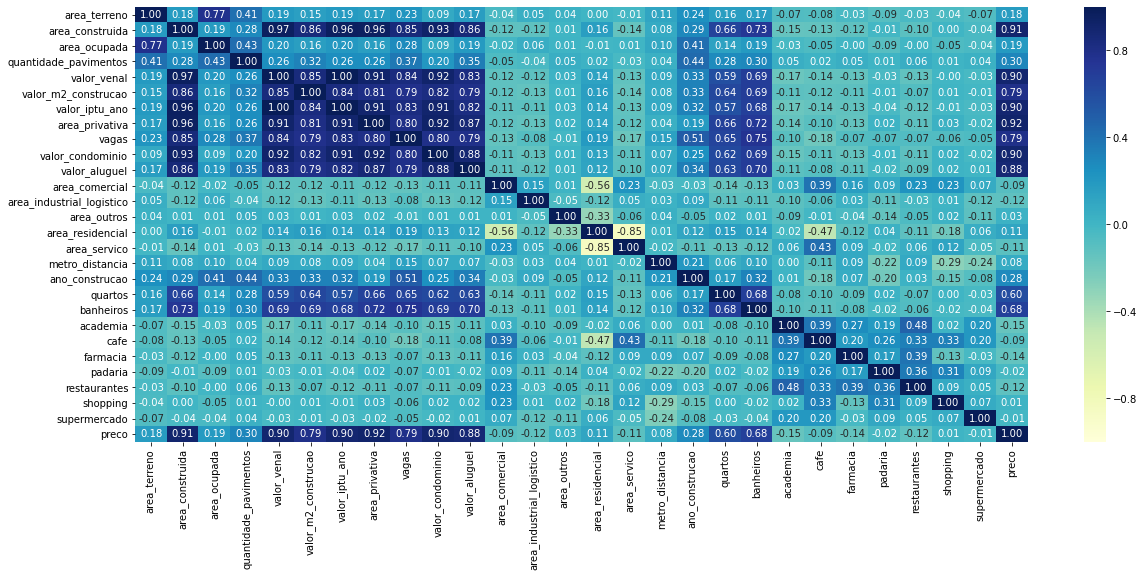

In [13]:
#Analisando a correlação entre as variáveis
plt.figure(figsize = (20,8))
sns.heatmap(base2[var_numerica + [target]].corr(), annot=True, fmt=".2f",cmap="YlGnBu",vmin=-1, vmax=1)
plt.show()

Com a remoção de variáveis, a tabela ficou com uma dimensão menor, o que pode facilitar nossa modelagem

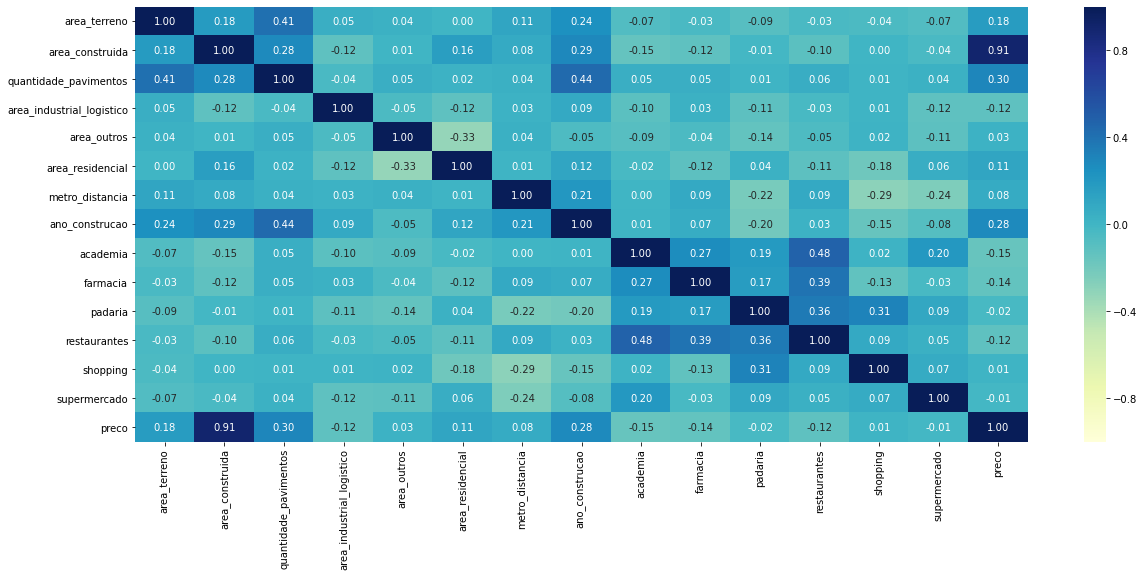

In [14]:
var_remover = ['valor_venal','valor_m2_construcao','valor_iptu_ano','area_privativa','valor_condominio','area_comercial',
              'valor_aluguel','area_servico', 'banheiros','vagas','quartos','cafe','area_ocupada']

plt.figure(figsize = (20,8))
sns.heatmap(base2[var_numerica + [target]].drop(columns = var_remover).corr(), annot=True, fmt=".2f",cmap="YlGnBu",vmin=-1, vmax=1)
plt.show()

In [15]:
base3 = base2.drop(columns = var_remover)

## Criando gráficos para entender as relações entre as variáveis

Vamos verificar como é a distribuição da variável alvo

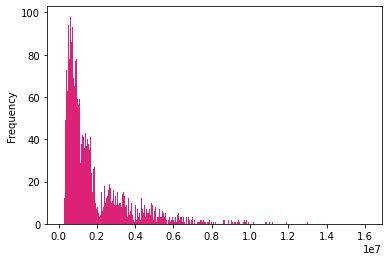

In [16]:
base3[target].plot(kind = "hist", bins = 1000,color = color)
plt.show()

In [17]:
#Verificando a faixa de preço e quantidade
pd.cut(base3[target],10).value_counts().reset_index().rename(columns = {'index':'faixa_preco'})

faixa_preco  preco
0   (194671.875, 1800483.5]   5057
1    (1800483.5, 3390396.0]   1191
2    (3390396.0, 4980308.5]    621
3    (4980308.5, 6570221.0]    307
4    (6570221.0, 8160133.5]    134
5    (8160133.5, 9750046.0]     77
6   (9750046.0, 11339958.5]     43
7  (11339958.5, 12929871.0]     17
8  (12929871.0, 14519783.5]      4
9  (14519783.5, 16109696.0]      1

Ela se assemelha a uma distribuição exponencial (ou mesmo gamma). Vamos realizar um boxcox para evidenciar a distribuição

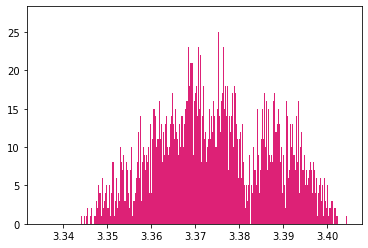

In [18]:
dist,lmd = boxcox(base3[target])
plt.hist(dist,bins = 1000,color = color)
plt.show()

Caso tivesse um comportamento exponencial, a função boxcox poderia revelar uma normalidade nos dados transformados (o que atenderia algumas suposições de modelagem liner).
Contudo, já pelo histograma, podemos concluir que essa normalidadea não está satisfeita. Portanto, vamos seguir com o estudo sem realizar transformações na variável alvo

Para as variáveis numéricas, podemos verificar o scatter plot, comparando com outras variáveis numéricas, inclusive a variável preço (variável alvo)

In [19]:
var_numerica3 = [var for var in base3.columns if var in var_numerica]
var_categorica3 = var_categorica.copy()

Algumas análises a respeito da distribuições dos dados:

* Em nossa base existem casas mais distantes do metro do que próximas, contudo, pelo gráfico distancia do metro x preço, não há uma correlação explícita positiva;
* Interessante nota, como foi visto na correlação, que ao passo que há mais restaurantes nas redondezas, a margem de preço das casas diminui;
* A área construída tem um relação direta com o preço: quanto maior a área, maior o preço (o que faz todo o sentido);
* O fato de estar ou não próximo a um shopping não evidencia valores distintos de preços;
* Parece haver uma tendência ao fato de onde temos mais academias, também termos mais restaurantes.

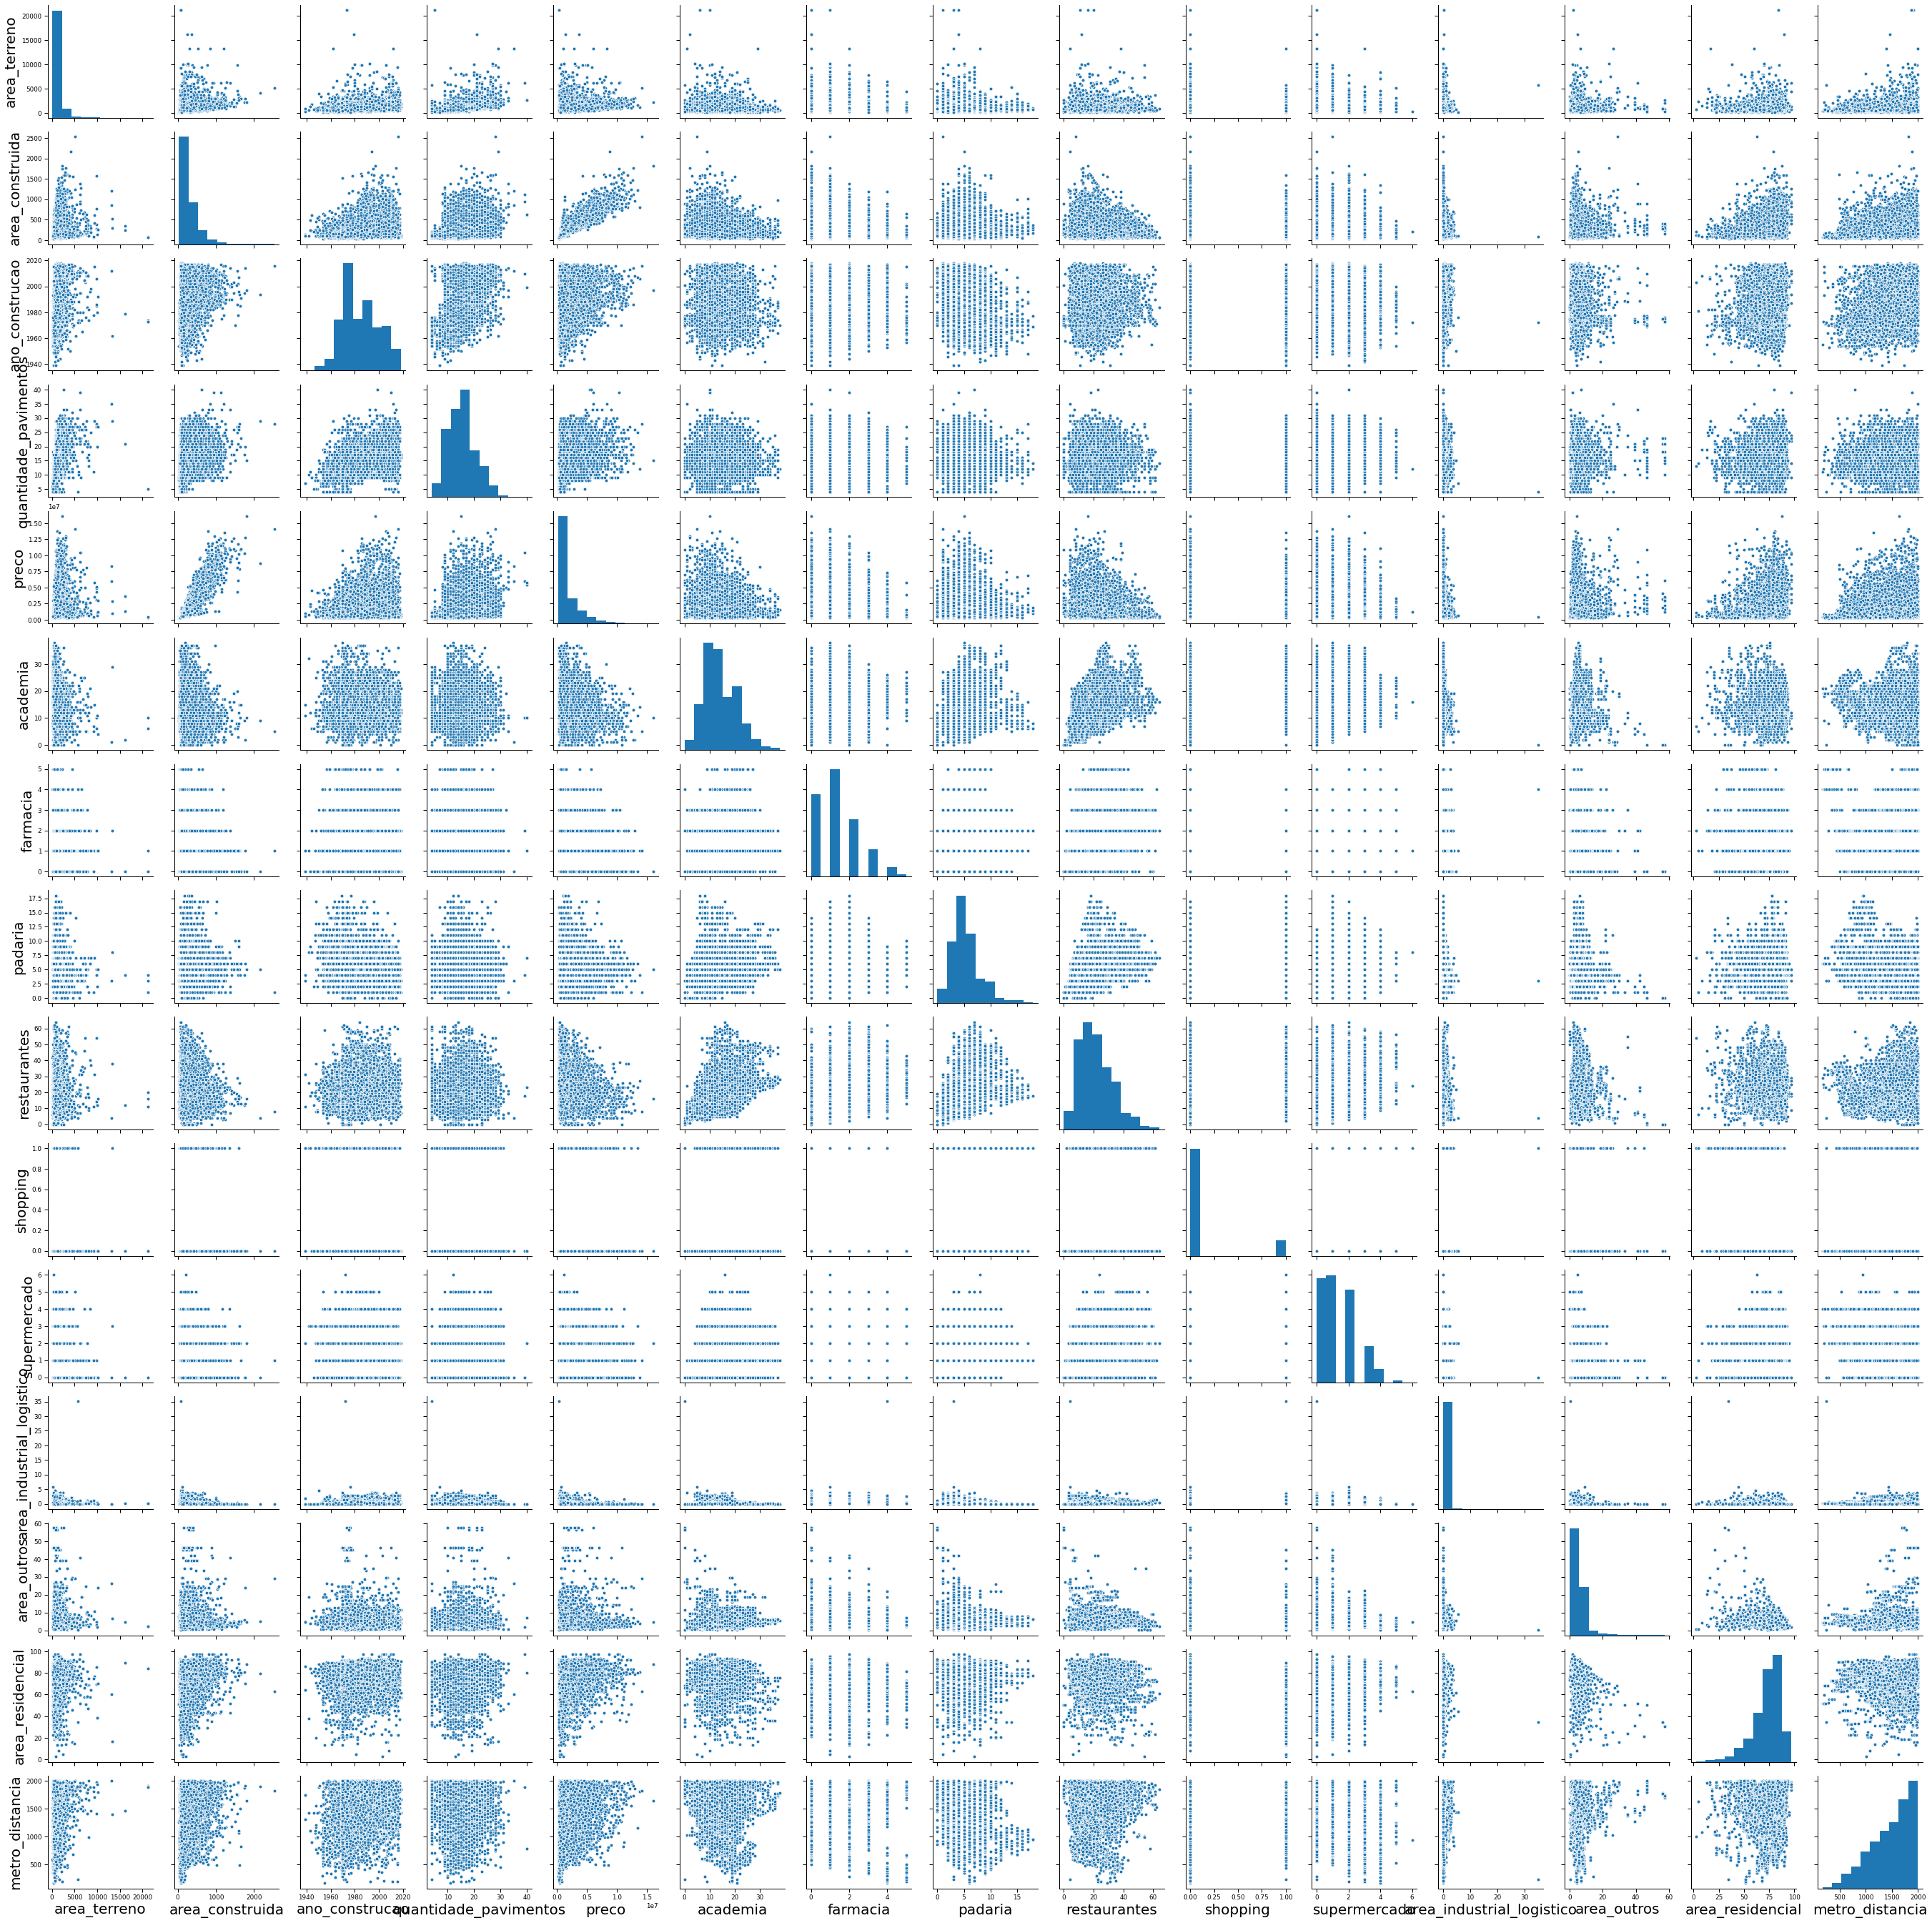

In [160]:
sns.set_context("paper", rc={"axes.labelsize":20})
ax = sns.pairplot(base3)

Vamos verificar como se comporta o preço com relação às variáveis categóricas

* Existem alguns bairros que há uma dispersão maior nos preços. Tal informação poderia ser avaliada junto a área de negócio;
* Outros bairros apresentam um preço bem concentrado, indicando que os preços naquele bairro não variam
* Nota-se que, por mais pequena que seja a diferença, a mediana dos preços em áreas planas com facilidade para caminhar tende a ser um fator relevante para os preços dos imóveis (maior facilidade em caminhadas estaria correlacionado a um maior preço);
* Com relação a linha do metro, existem linhas com medianas maiores. Seria interessante analisar onde estariam essas linhas, geograficamente, para evidenciar ainda mais a relação;
* O mesmo acontece para as estações, em alguns casos temos diferenças mínimas preço(talvez causados pelo desbalanceamento de classes) __verificar__, e outros casos com uma variabilidade alta.

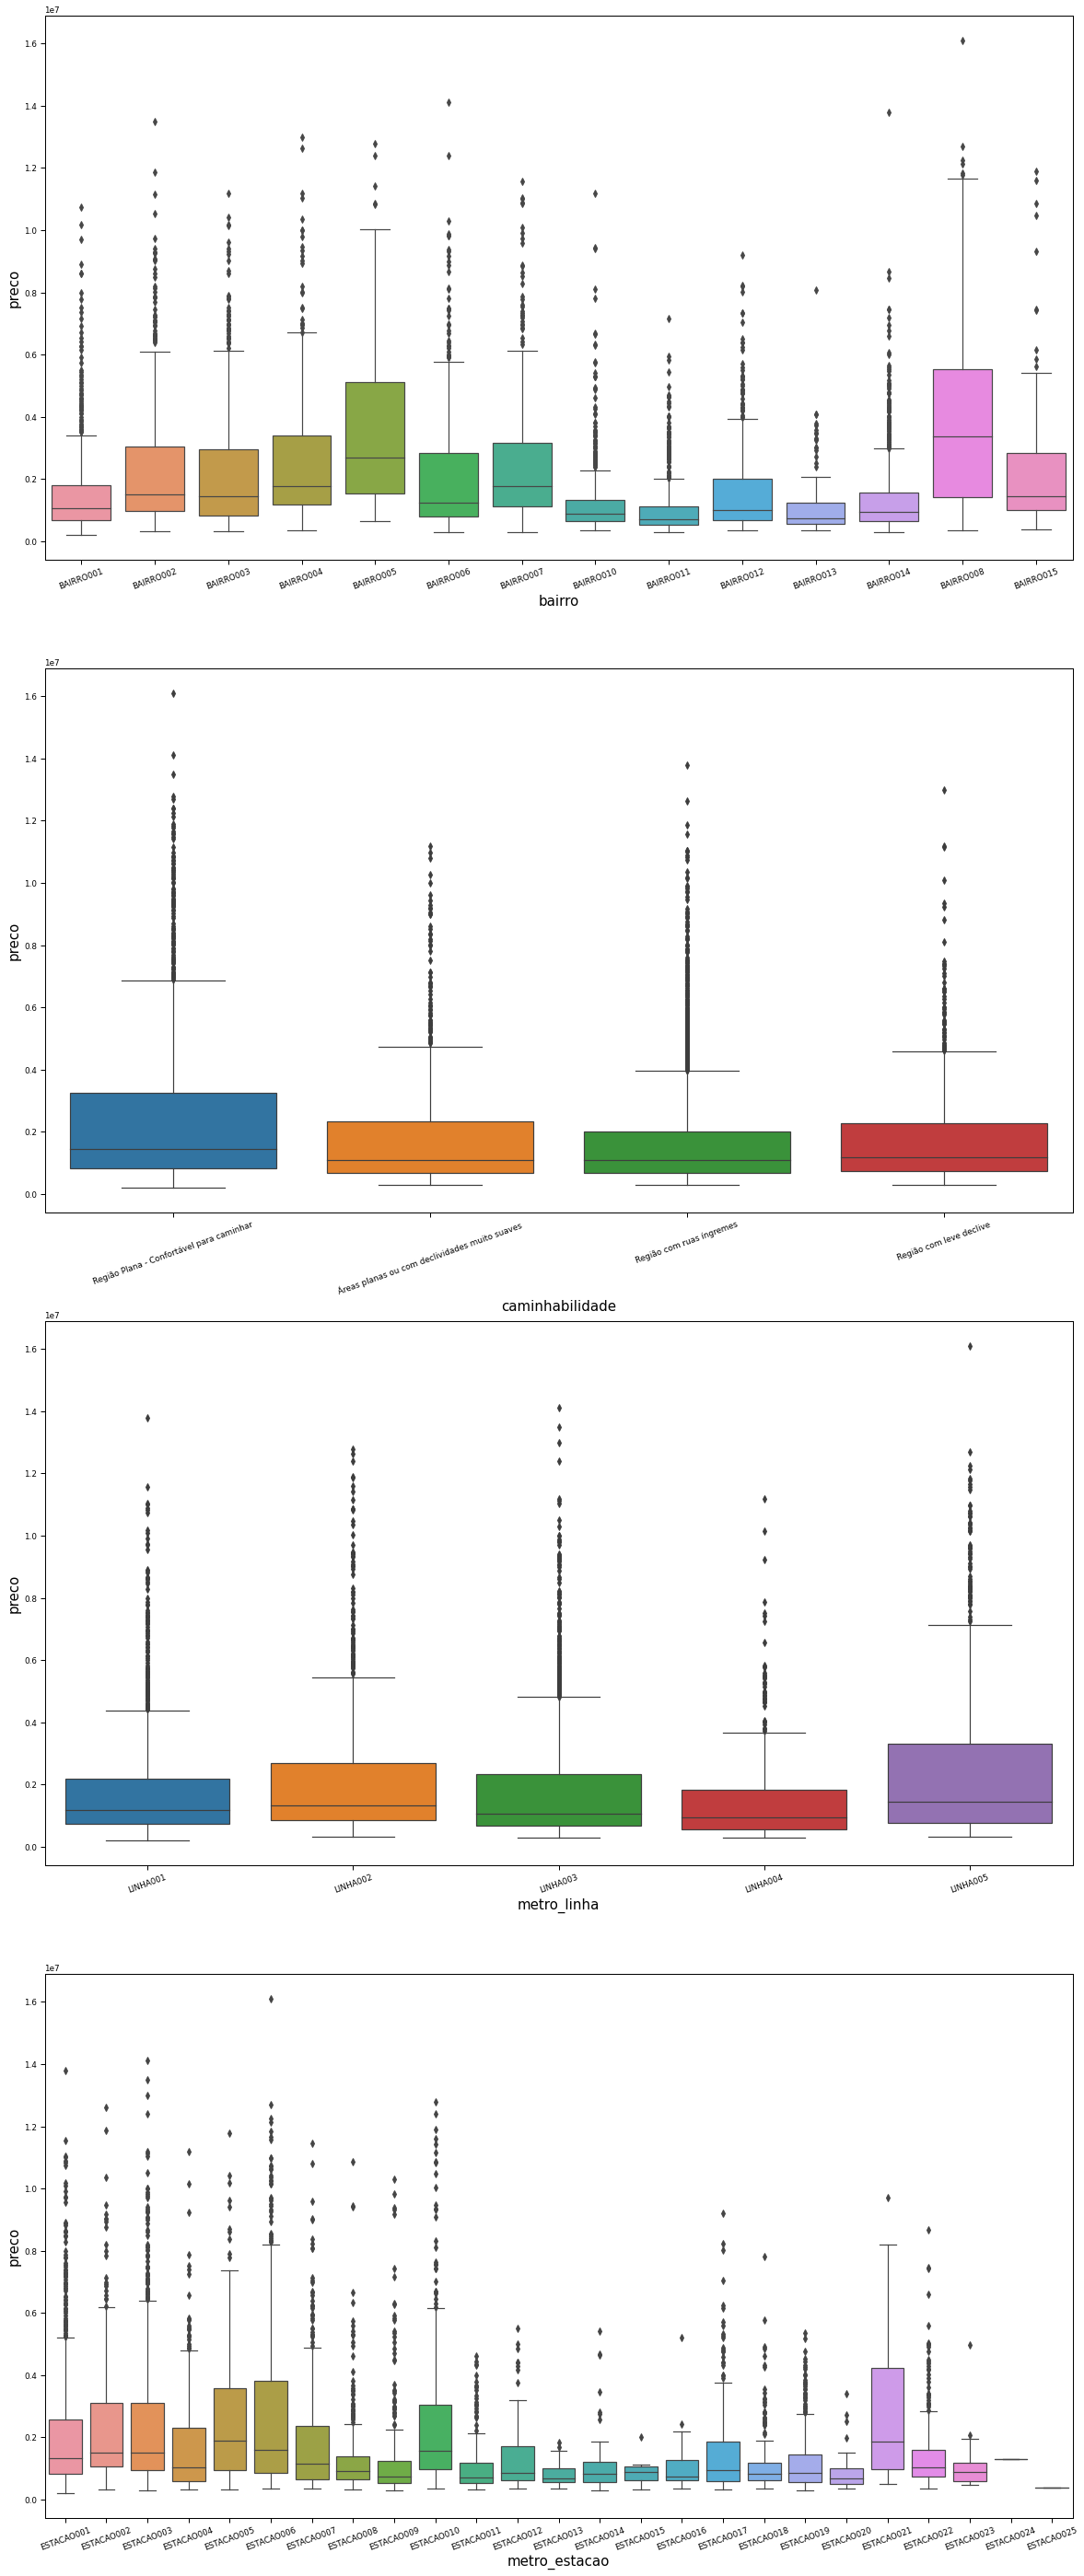

In [20]:
#BoxPlot para cada uma das variáveis categoricas
plt.figure(figsize=(20,50))
sns.set_context("paper", rc={"axes.labelsize":15})
for i,var in enumerate(var_categorica3):
    plt.subplot(len(var_categorica3),1,i+1)
    chart = sns.boxplot(base3[var],base3.preco)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=20)
plt.show()

Vamos verificar, para a classe metro_estacao, o volume de dados para cada uma:
* Como foi verificado, a diferença na variação de preços, por exemplo, na estação 24 não é por conta dos preços estarem extremamente relacionados com o fato da estação estar em um ponto relevante da cidade: apenas temos poucos dados (no caso 1). Contudo, não podemos descartar a hipótese que isso poderia ocorrer, apenas não podemos ter certeza que para a estação 24 existe uma espécie de "preço tabelado"

In [21]:
base3["metro_estacao"].value_counts()

ESTACAO003    1223
ESTACAO001    1195
ESTACAO006     640
ESTACAO007     487
ESTACAO010     420
ESTACAO019     386
ESTACAO002     379
ESTACAO008     373
ESTACAO009     348
ESTACAO004     323
ESTACAO005     299
ESTACAO022     268
ESTACAO018     262
ESTACAO017     252
ESTACAO011     224
ESTACAO012      87
ESTACAO014      66
ESTACAO021      62
ESTACAO013      50
ESTACAO016      46
ESTACAO020      32
ESTACAO023      22
ESTACAO015       6
ESTACAO025       1
ESTACAO024       1
Name: metro_estacao, dtype: int64

## Realizando o encoder das variáveis categoricas

Para as variáveis metro_linha, bairro e caminhabilidade, vamos transformar os valores de suas classes no valor de suas medianas das quantidades, para que o modelo possa utilizar esses dados (*dados categóricos devem ser convertidos em valores númericos, pois é isso que o computador "entende"*)

Para a variável metro_estacao, vamos utilizar um encoder ordinal, substituindo os valores por uma sequencia numerica

In [22]:
#Encoder de medianas dos dados bairro, caminhabilidade de metro linha
dicionario_medianas = {"bairro": 0,"caminhabilidade": 0,"metro_linha": 0}
for chave,valor in dicionario_medianas.items():
    dicionario_medianas[chave] = base3.groupby(chave).preco.median()

categoricas_mediana = base3[["bairro","caminhabilidade","metro_linha"]]

for chave,valor in dicionario_medianas.items():
    categoricas_mediana[chave] = categoricas_mediana[chave].replace(valor.index, list(valor))

categoricas_mediana=categoricas_mediana.reset_index(drop=True)
categoricas_mediana.tail()

bairro  caminhabilidade  metro_linha
7447   873472.0        1457905.5    1320641.0
7448  1013595.0        1082772.0    1320641.0
7449  1013595.0        1082772.0    1320641.0
7450   935767.0        1176844.0    1173731.0
7451   935767.0        1176844.0    1173731.0

In [23]:
#Encoder para metro_estacao

#Inicializando a classe OrdinalEncoder
encoder = OrdinalEncoder()

#Realizando o encodign das variaveis categoricas
categoricas_base4_metro_estacao = pd.DataFrame(encoder.fit(np.array(base3["metro_estacao"]).reshape(-1,1)).transform(np.array(base3["metro_estacao"]).reshape(-1,1)))
categoricas_base4_metro_estacao.columns = ["metro_estacao"]
categoricas_base4_metro_estacao.tail()

metro_estacao
7447            9.0
7448            7.0
7449            7.0
7450           18.0
7451           18.0

In [24]:
#Unindo as variáveis categóricas e numéricas

#Criando uma base copia de base3 sem as variaveis categoricas
base4 = base3.drop(columns = var_categorica3).reset_index(drop= True).copy()

#Unindo as variaveis
base4 = pd.concat([base4,categoricas_base4_metro_estacao,categoricas_mediana],axis=1)
base4.shape

(7452, 19)

# Dividindo as variáveis em treino e teste

In [25]:
#Vamos inserir um random state para que possamos recriar a mesma base sempre para testes futuros
X_train, X_test, y_train, y_test = train_test_split(base4.drop(columns = target),base4[target], test_size = 0.3, random_state = 10)

# Alteração na escala das variáveis

As variáveis possuem escalas muito distintas, o que dificulta na modelagem. Por isso, vamos colocá-las na mesma escala

In [26]:
min_max = MinMaxScaler()
min_max.fit(X_train)
X_train_scaler = min_max.transform(X_train)

## Feature Selection

Vamos aplicar uma técnica de seleção de variáveis, com a finalidade de encontrar as variáveis mais relevantes para a modelagem. Vamos utilizar o RandomForest

In [27]:
rf_feature = RandomForestRegressor()

In [28]:
feat_selec = rf_feature.fit(X_train_scaler,y_train)

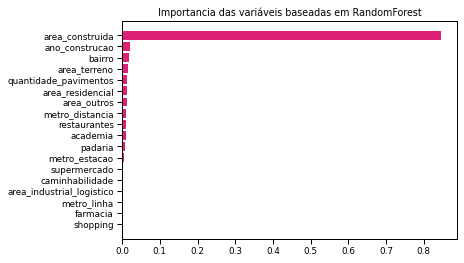

In [29]:
importancias = pd.DataFrame({"Variavel": base4.drop(columns = target).columns,"Importancia": feat_selec.feature_importances_})
plt.barh(importancias.sort_values("Importancia").Variavel,importancias.sort_values("Importancia").Importancia, color = '#dd2176')
plt.title("Importancia das variáveis baseadas em RandomForest")
plt.show()

A variável area_construida, pela sua alta correlação com a variável alvo, dificulta perceber a diferença entre as relevancias das variáveis. Vamos fazer o mesmo plot sem a área construída

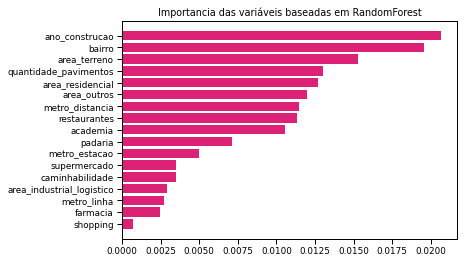

In [30]:
plt.barh(importancias[importancias["Variavel"] != "area_construida"].sort_values("Importancia").Variavel,
         importancias[importancias["Variavel"] != "area_construida"].sort_values("Importancia").Importancia,
         color = color)
plt.title("Importancia das variáveis baseadas em RandomForest")
plt.show()

Vamos então decidir qual as variáveis que levaremos para o modelo

A técnica de Random Forest para decisão de variáveis para selecionarmos para modelagem é apenas um indicativo. Uma além dessa informação, as informações advindas da área de negócio são de extrema relevancia

In [31]:
var_modelagem = ['area_construida',
                'ano_construcao',
                'bairro',
                'area_terreno',
                'quantidade_pavimentos',
                'area_outros',
                'area_residencial',
                'academia',
                'metro_distancia',
                'restaurantes']
colunas_X = [list(base4.drop(columns = target).columns).index(var) for var in var_modelagem]

In [32]:
X_train_scaler_feature = X_train_scaler[:,colunas_X]

## Teste com diferentes modelos

Vamos realizar testes com diferentes modelos de regressão e avaliar cada modelo com a mesma métrica

In [34]:
#Inicializando uma lista de modelos
models = []
models.append(('LIN',LinearRegression()))
models.append(('LAS',Lasso()))
models.append(('LLS',LassoLars()))
models.append(('NET',ElasticNet()))
models.append(('RDG',Ridge()))
models.append(('GAM',GammaRegressor())) #regressor generalizavel
models.append(('BAY',BayesianRidge()))
models.append(('HUB',HuberRegressor()))
models.append(('PAR',PassiveAggressiveRegressor()))
models.append(('BAG',BaggingRegressor()))
models.append(('GBR',GradientBoostingRegressor(loss='quantile'))) #regressão quantilica
models.append(('ABR',AdaBoostRegressor()))
models.append(('ETR',ExtraTreesRegressor()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGR',XGBRFRegressor()))
models.append(('XGB',XGBRegressor()))

In [52]:
# Avaliando cada modelo em um loop
def compara_modelo_treino(modelos,X_avaliacao,y_avaliacao,num_folds = 8,scoring = {'RMSE': 'neg_root_mean_squared_error', 'R2': 'r2'}):

    X = X_avaliacao.copy()
    Y = y_avaliacao.copy()

    resultados = {'Modelo':[]}
    for cada_score,val in scoring.items():
        resultados.update({cada_score: []})

    for nome, modelo in modelos:
        t0= time.clock()
        kfold = KFold(n_splits = num_folds)
        cv_results = cross_validate(estimator = modelo,
                                    X = X, 
                                    y = Y, 
                                    cv = kfold, 
                                    scoring = scoring)

        resultados['Modelo'].extend([nome]*num_folds)
        for cada_score,val in scoring.items():
            resultados[cada_score].extend(cv_results["".join(("test_",cada_score))])

        t1 = time.clock()-t0

        msg = nome + " - Tempo de execucao: " + str(round(t1,0)) + "s - "
        for cada_score,val in scoring.items():
            msg =  msg + cada_score + ": " + \
                   str(round(np.mean(cv_results["".join(("test_",cada_score))]),3)) + " & " + \
                   str(round(np.std(cv_results["".join(("test_",cada_score))]),3)) + " - "
        print(msg)

    df_resultados = pd.DataFrame(resultados)
    plt.figure(figsize=(20,10))
    for colunas in range(1,len(df_resultados.columns)):
        plt.subplot(1,len(scoring),colunas)
        sns.boxplot(data = pd.DataFrame(resultados).iloc[:,[0,colunas]],x = "Modelo",y = df_resultados.columns[colunas])
    plt.show()


In [53]:
# Vamos testar vários modelos algumas vezes (8 vezes para cada um) e verificar a média de resultados encontrados e suas variações
compara_modelo_treino(models,X_train_scaler_feature,y_train)

LIN - Tempo de execucao: 0.0s - RMSE: -787381.953 & 49179.22 - R2: 0.825 & 0.023 - 
LAS - Tempo de execucao: 0.0s - RMSE: -787381.846 & 49180.562 - R2: 0.825 & 0.023 - 
LLS - Tempo de execucao: 0.0s - RMSE: -787381.425 & 49187.201 - R2: 0.825 & 0.023 - 
NET - Tempo de execucao: 0.0s - RMSE: -1827076.886 & 84930.441 - R2: 0.066 & 0.002 - 
RDG - Tempo de execucao: 0.0s - RMSE: -788762.772 & 46864.947 - R2: 0.825 & 0.023 - 
GAM - Tempo de execucao: 0.0s - RMSE: -1858639.215 & 87682.941 - R2: 0.034 & 0.002 - 
BAY - Tempo de execucao: 0.0s - RMSE: -1892205.419 & 88293.326 - R2: -0.002 & 0.002 - 
HUB - Tempo de execucao: 1.0s - RMSE: -1559751.904 & 73515.194 - R2: 0.319 & 0.009 - 
PAR - Tempo de execucao: 4.0s - RMSE: -1937186.671 & 102241.864 - R2: -0.049 & 0.017 - 
BAG - Tempo de execucao: 3.0s - RMSE: -771527.917 & 33091.463 - R2: 0.833 & 0.016 - 
GBR - Tempo de execucao: 10.0s - RMSE: -1075656.585 & 53846.503 - R2: 0.674 & 0.043 - 
ABR - Tempo de execucao: 3.0s - RMSE: -1066106.076 & 974

O modelo com melhores resultados foi o ETR

# Otimização de resultados - Redução de dimensionalidade utilizando PCA

Vamos tentar realizar uma redução de dimensionalidade utilizando PCA.

Vamos verificar quantas variáveis conseguimos reduzir

Para a aplicação do PCA, será necessário não somente deixar os dados na mesma escala, mas devemos também padronizar os dados. Portanto, vamos realizar mais uma alteração nos dados

In [143]:
ss = StandardScaler()
ss.fit(X_train_scaler)
X_train_ss_scaler = ss.transform(X_train_scaler)

In [145]:
#Vamos varrer o PCA com n quantidade de componentes, até chegarmos a quantidade de variaveis do problema
X_pca = X_train_ss_scaler.copy()
explicacao_variancia = []
for n in range(1,X_pca.shape[1]+1):
    pca = PCA(n_components=n)
    #print(pca.fit(X_pca).explained_variance_ratio_)
    explicacao_variancia.append(np.sum(pca.fit(X_pca).explained_variance_ratio_))

sns.set_context("paper", rc={"axes.labelsize":10})
plt.plot(range(1,X_pca.shape[1]+1),explicacao_variancia,'o',color = color)
plt.xticks(range(1,X_pca.shape[1]+1))
plt.title("Explicação (%) das variáveis")
plt.ylabel("Taxa de explicação")
plt.xlabel("Número de componentes")
plt.show()

In [146]:
explicacao_variancia

[0.1307188457544908,
 0.2604452816177566,
 0.3787467673511565,
 0.4753794231615388,
 0.554123972162341,
 0.6141693573338882,
 0.6713221201133024,
 0.7169973021571892,
 0.7589902630989471,
 0.7963280388841768,
 0.8312792498700391,
 0.8625710305448464,
 0.8909452866279379,
 0.9163870415535247,
 0.9392410770012503,
 0.9613829929045971,
 0.981285359143102,
 0.9999999999999999]

Pelos resultados do PCA, vamos utilizar 14 variáveis, que conseguem explicar mais 90% dos dados

In [220]:
compara_modelo_treino(models,PCA(n_components=14).fit_transform(X_train_ss_scaler),y_train)

LIN - Tempo de execucao: 0.0s - RMSE: -837371.284 & 35524.463 - R2: 0.802 & 0.025 - 
LAS - Tempo de execucao: 0.0s - RMSE: -837371.281 & 35524.381 - R2: 0.802 & 0.025 - 
LLS - Tempo de execucao: 0.0s - RMSE: -837370.697 & 35520.529 - R2: 0.802 & 0.025 - 
NET - Tempo de execucao: 0.0s - RMSE: -982303.417 & 31855.155 - R2: 0.729 & 0.02 - 
RDG - Tempo de execucao: 0.0s - RMSE: -837371.953 & 35511.931 - R2: 0.802 & 0.025 - 
GAM - Tempo de execucao: 0.0s - RMSE: -1301592.491 & 226566.312 - R2: 0.513 & 0.183 - 
BAY - Tempo de execucao: 0.0s - RMSE: -837376.54 & 35475.293 - R2: 0.802 & 0.025 - 
HUB - Tempo de execucao: 0.0s - RMSE: -856002.926 & 34457.846 - R2: 0.794 & 0.024 - 
PAR - Tempo de execucao: 2.0s - RMSE: -952220.817 & 34054.8 - R2: 0.745 & 0.019 - 
BAG - Tempo de execucao: 3.0s - RMSE: -933511.904 & 28714.174 - R2: 0.755 & 0.023 - 
GBR - Tempo de execucao: 12.0s - RMSE: -1280745.883 & 42870.153 - R2: 0.537 & 0.059 - 
ABR - Tempo de execucao: 4.0s - RMSE: -1469874.716 & 48760.659 - 

A aplicação do PCA não trouxe melhoras aos modelos

# Otimização de resultados - Alteração do método de feature selection

Vamos utilizar do SelecKBest para selecionar os melhores resultados, com base em suas métricas

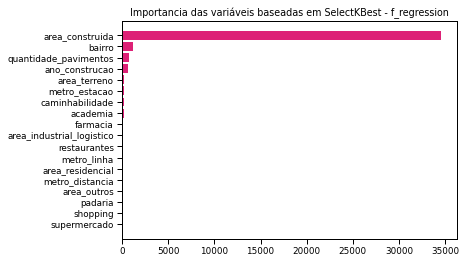

In [147]:
skbest_f_regression = SelectKBest(score_func=f_regression,k="all").fit(base4.drop(columns = target),base4[target])
importancias_skbest_f_regression = pd.DataFrame({"Variavel": base4.drop(columns = target).columns,
                                                 "Importancia":skbest_f_regression.scores_})

plt.barh(importancias_skbest_f_regression.sort_values("Importancia").Variavel,
         importancias_skbest_f_regression.sort_values("Importancia").Importancia,
         color = color)
plt.title("Importancia das variáveis baseadas em SelectKBest - f_regression")
plt.show()

Os resultados foram semelhantes ao apresentado pela metodologia de RandomForest

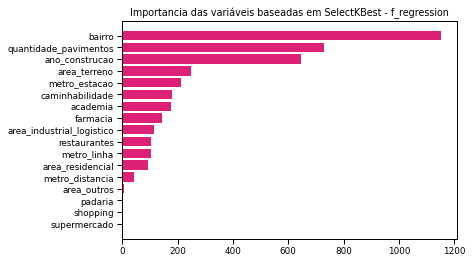

In [148]:
plt.barh(importancias_skbest_f_regression[importancias_skbest_f_regression["Variavel"] != "area_construida"].sort_values("Importancia").Variavel,
         importancias_skbest_f_regression[importancias_skbest_f_regression["Variavel"] != "area_construida"].sort_values("Importancia").Importancia,
         color = color)
plt.title("Importancia das variáveis baseadas em SelectKBest - f_regression")
plt.show()

Vamos aplicar o método de informação mútua e verificar os reultados

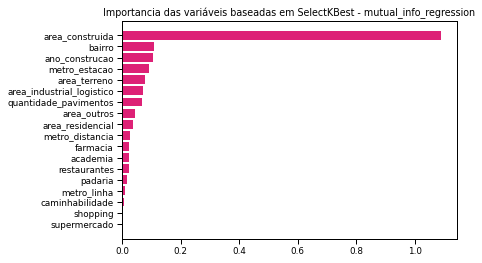

In [149]:
skbest_mutual = SelectKBest(score_func=mutual_info_regression,k="all").fit(base4.drop(columns = target),base4[target])
importancias_skbest_mutual = pd.DataFrame({"Variavel": base4.drop(columns = target).columns,
                                                 "Importancia":skbest_mutual.scores_})

plt.barh(importancias_skbest_mutual.sort_values("Importancia").Variavel,
         importancias_skbest_mutual.sort_values("Importancia").Importancia,color = color)
plt.title("Importancia das variáveis baseadas em SelectKBest - mutual_info_regression")
plt.show()

Para o caso do SelectKBest utilizando informação mútua, as variáveis escolhidas foram diferentes. Vamos testar os modelos com essa nova abordagem

In [46]:
var_modelagem_mutual = ['area_construida',
                        'ano_construcao',
                        'bairro',
                        'metro_estacao',
                        'area_terreno',
                        'area_industrial_logistico',
                        'quantidade_pavimentos']
colunas_X_mutual = [list(base4.drop(columns = target).columns).index(var) for var in var_modelagem_mutual]
X_train_scaler_feature_mutual = X_train_scaler[:,colunas_X]

In [251]:
compara_modelo_treino(models,X_train_scaler_feature_mutual,y_train)

LIN - Tempo de execucao: 0.0s - RMSE: -787381.953 & 49179.22 - R2: 0.825 & 0.023 - 
LAS - Tempo de execucao: 0.0s - RMSE: -787381.846 & 49180.562 - R2: 0.825 & 0.023 - 
LLS - Tempo de execucao: 0.0s - RMSE: -787381.425 & 49187.201 - R2: 0.825 & 0.023 - 
NET - Tempo de execucao: 0.0s - RMSE: -1827076.886 & 84930.441 - R2: 0.066 & 0.002 - 
RDG - Tempo de execucao: 0.0s - RMSE: -788762.772 & 46864.947 - R2: 0.825 & 0.023 - 
GAM - Tempo de execucao: 0.0s - RMSE: -1858639.215 & 87682.941 - R2: 0.034 & 0.002 - 
BAY - Tempo de execucao: 0.0s - RMSE: -1892205.419 & 88293.326 - R2: -0.002 & 0.002 - 
HUB - Tempo de execucao: 0.0s - RMSE: -1559751.904 & 73515.194 - R2: 0.319 & 0.009 - 
PAR - Tempo de execucao: 2.0s - RMSE: -1937189.344 & 102243.535 - R2: -0.049 & 0.017 - 
BAG - Tempo de execucao: 2.0s - RMSE: -792085.026 & 39500.969 - R2: 0.824 & 0.011 - 
GBR - Tempo de execucao: 5.0s - RMSE: -1072521.079 & 54060.077 - R2: 0.676 & 0.043 - 
ABR - Tempo de execucao: 2.0s - RMSE: -1082051.893 & 8014

Não houve melhoras significativas alterando a forma de realizar seleção de atributos

# Otimização de resultados - Alteração dos hiperparâmetros do melhor modelo

O melhor modelo encontrado, utilizando os modelos padrões, foi o ETR, utilizando RandomForest como seletor de atributos. Vamos fazer um alterações em seus hiperparâmetros e vamos verificar o que conseguimos extrair de valor

In [91]:
# Vamos utilizar do GridSearch para realizar a busca
param_grid = {"n_estimators": [100,50,200,500],
             'criterion': ['mse'],
             'max_depth': [None,50,100],
             'min_samples_split': [2,5,10],
             'min_samples_leaf':[1,5,9],
             'max_leaf_nodes': [None,5,10],
             'min_impurity_decrease': [0,0.001,0.01]
             }

GD = GridSearchCV(n_jobs=4,
                 cv=8,
                 estimator = ExtraTreesRegressor(),
                 param_grid = param_grid,
                 scoring=('neg_root_mean_squared_error','r2'),
                 refit = 'neg_root_mean_squared_error',
                 return_train_score=True,
                 verbose = 1)    

In [92]:
GD.fit(X_train_scaler_feature,y_train)

Fitting 8 folds for each of 972 candidates, totalling 7776 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   23.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  6.6min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed: 14.0min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed: 15.6min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed: 21.1min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done 7776 out of 7776 | elapsed: 24.1min finished


GridSearchCV(cv=8, estimator=ExtraTreesRegressor(), n_jobs=4,
             param_grid={'criterion': ['mse'], 'max_depth': [None, 50, 100],
                         'max_leaf_nodes': [None, 5, 10],
                         'min_impurity_decrease': [0, 0.001, 0.01],
                         'min_samples_leaf': [1, 5, 9],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 50, 200, 500]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('neg_root_mean_squared_error', 'r2'), verbose=1)

Vamos recuperar os melhores parâmetros encontrados

Percebe-se que eles são diferentes dos hiperparâmetros padrão (que podem ser encontrados em https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

In [123]:
GD.best_params_

{'criterion': 'mse',
 'max_depth': 50,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.001,
 'min_samples_leaf': 5,
 'min_samples_split': 5,
 'n_estimators': 50}

In [114]:
print("".join(("O modelo apresentou um RMSE médio de ",str(round(-GD.best_score_,1)), ", sendo este o melhor resultado encontrado até o momento")))

O modelo apresentou um RMSE médio de 733229.6, sendo este o melhor resultado encontrado até o momento


Vamos salvar o modelo que temos

In [97]:
pickle.dump(GD.best_estimator_,open("modelo.plk","wb"))

# Avaliando o modelo nos dados de teste

In [38]:
modelo = pickle.load(open("modelo.plk","rb"))

Para avaliar o modelo para os dados de teste, precisamos realizar os mesmos tratamentos que fizemos aos dados de treino aos de teste

In [35]:
#Altera a escala dos dados
X_test_scaler = min_max.transform(X_test)

#Aplica a feature selection
X_test_scaler_feature = X_test_scaler[:,colunas_X]

In [40]:
#Não há a metrica rmse construida como função no sklearn, apenas o mse. Para chegar onde queremos, basta estrair a raiz quadrada
def rmse(y_true,y_pred):
    return(np.sqrt(mean_squared_error(y_true,y_pred)))

In [45]:
# Vamos avaliar o modelo para duas métricas: o RMSE e o R²
def apresenta_resultados(X,y,m):
    RMSE_modelo = rmse(y_true = y,
                       y_pred = m.predict(X))

    R2_modelo = r2_score(y_true = y,
                         y_pred = m.predict(X))

    print("".join(("Este modelo apresentou um RMSE de ",str(round(RMSE_modelo,1)), " e R² de ",str(round(R2_modelo,2))," para os dados de teste")))

In [46]:
apresenta_resultados(X_test_scaler_feature,y_test,modelo)

Este modelo apresentou um RMSE de 683332.8 e R² de 0.88 para os dados de teste


Vamos plotar como deveria ter sido a saída e como ela ficou

In [185]:
def plot_real_estimativa(real,estimativa):
    plt.figure(figsize = (12,8))
    ax = sns.regplot(data = pd.DataFrame({"Preco": real, "Estimativa": estimativa}),
              x = "Estimativa", y = "Preco",scatter_kws={"color": color}, line_kws={"color": "blue"})
    plt.show()

In [186]:
plot_real_estimativa(y_test,modelo.predict(X_test_scaler_feature))

Este gráfico mostra a relação entre a saída esperada (Preço) e a saída estimada. Vemos que há diferenças entre os resultados, o que é esperado, mas os resultados são promissores

# Segunda Otimização dos Hiperparâmetro

Como pôde ser observado, os hiperparâmetros do melhor modelo foram diferentes daqueles padrão. Dessa forma, vamos realizar mais testes, garantindo apenas que a combinação melhor encontrada esteja entre as novas combinações

In [136]:
# Vamos utilizar do GridSearch para realizar uma nova busca
param_grid2 = {"n_estimators": [50,40,70],
             'criterion': ['mse'],
             'max_depth': [50,40,70],
             'min_samples_split': [5,4,7],
             'min_samples_leaf':[5,4,7],
             'max_leaf_nodes': [None,50,75,100],
             'min_impurity_decrease': [0.001,0.005,0.0005]
             }

GD2 = GridSearchCV(n_jobs=4,
                 cv=8,
                 estimator = ExtraTreesRegressor(),
                 param_grid = param_grid2,
                 scoring=('neg_root_mean_squared_error','r2'),
                 refit = 'neg_root_mean_squared_error',
                 return_train_score=True,
                 verbose = 1)    

In [137]:
GD2.fit(X_train_scaler_feature,y_train)

Fitting 8 folds for each of 972 candidates, totalling 7776 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:  6.1min
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 6042 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 7192 tasks      | elapsed: 10.6min
[Parallel(n_jobs=4)]: Done 7776 out of 7776 | elapsed: 11.4min finished


GridSearchCV(cv=8, estimator=ExtraTreesRegressor(), n_jobs=4,
             param_grid={'criterion': ['mse'], 'max_depth': [50, 40, 70],
                         'max_leaf_nodes': [None, 50, 75, 100],
                         'min_impurity_decrease': [0.001, 0.005, 0.0005],
                         'min_samples_leaf': [5, 4, 7],
                         'min_samples_split': [5, 4, 7],
                         'n_estimators': [50, 40, 70]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('neg_root_mean_squared_error', 'r2'), verbose=1)

Houve uma melhora no modelo, em relação ao primeiro

In [139]:
GD2.best_params_

{'criterion': 'mse',
 'max_depth': 70,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.005,
 'min_samples_leaf': 5,
 'min_samples_split': 4,
 'n_estimators': 50}

In [142]:
#Salvando modelo2
pickle.dump(GD2.best_estimator_,open("modelo2.plk","wb"))

In [33]:
modelo2 = pickle.load(open("modelo2.plk","rb"))

In [57]:
apresenta_resultados(X_test_scaler_feature,y_test,modelo2)

Este modelo apresentou um RMSE de 680554.3 e R² de 0.88 para os dados de teste


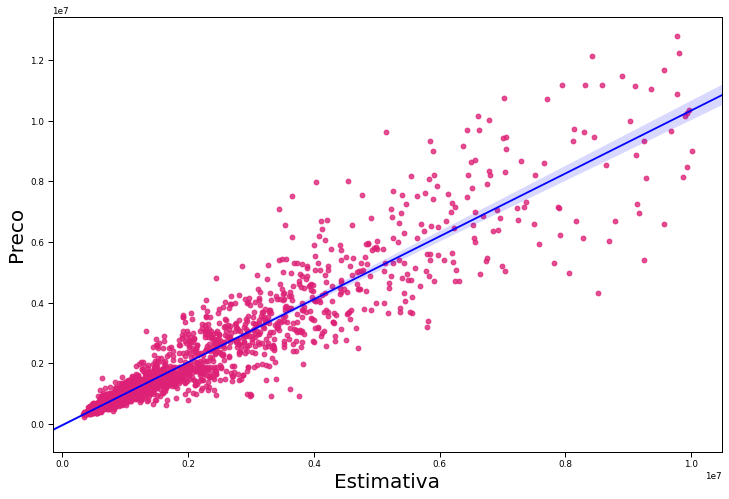

In [187]:
plot_real_estimativa(y_test,modelo2.predict(X_test_scaler_feature))

Os resultados encontrados por este modelo são melhores que o anterior. Tivemos um avanço em nossa modelagem

# Terceira Otimização dos Hiperparâmetro


Faremos o mesmo teste realizado na segunda tentativa, mas agora avaliando o segundo modelo como referencia

In [60]:

# Vamos utilizar do GridSearch para realizar uma nova busca
param_grid3 = {"n_estimators": [50],
             'criterion': ['mse'],
             'max_depth': [70,80,90],
             'min_samples_split': [4,3,2],
             'min_samples_leaf':[5,6,3],
             'max_leaf_nodes': [None,300,500],
             'min_impurity_decrease': [0.005,0.003,0.008]
             }

GD3 = GridSearchCV(n_jobs=4,
                 cv=8,
                 estimator = ExtraTreesRegressor(),
                 param_grid = param_grid3,
                 scoring=('neg_root_mean_squared_error','r2'),
                 refit = 'neg_root_mean_squared_error',
                 return_train_score=True,
                 verbose = 1)  

In [61]:
GD3.fit(X_train_scaler_feature,y_train)

Fitting 8 folds for each of 243 candidates, totalling 1944 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   27.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 1944 out of 1944 | elapsed:  3.9min finished


GridSearchCV(cv=8, estimator=ExtraTreesRegressor(), n_jobs=4,
             param_grid={'criterion': ['mse'], 'max_depth': [70, 80, 90],
                         'max_leaf_nodes': [None, 300, 500],
                         'min_impurity_decrease': [0.005, 0.003, 0.008],
                         'min_samples_leaf': [5, 6, 3],
                         'min_samples_split': [4, 3, 2], 'n_estimators': [50]},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=('neg_root_mean_squared_error', 'r2'), verbose=1)

In [62]:
GD3.best_params_

{'criterion': 'mse',
 'max_depth': 90,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.005,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 50}

In [63]:
#Salvando modelo3
pickle.dump(GD3.best_estimator_,open("modelo3.plk","wb"))

In [154]:
modelo3 = pickle.load(open("modelo3.plk","rb"))

In [155]:
apresenta_resultados(X_test_scaler_feature,y_test,modelo3)

Este modelo apresentou um RMSE de 689587.0 e R² de 0.87 para os dados de teste


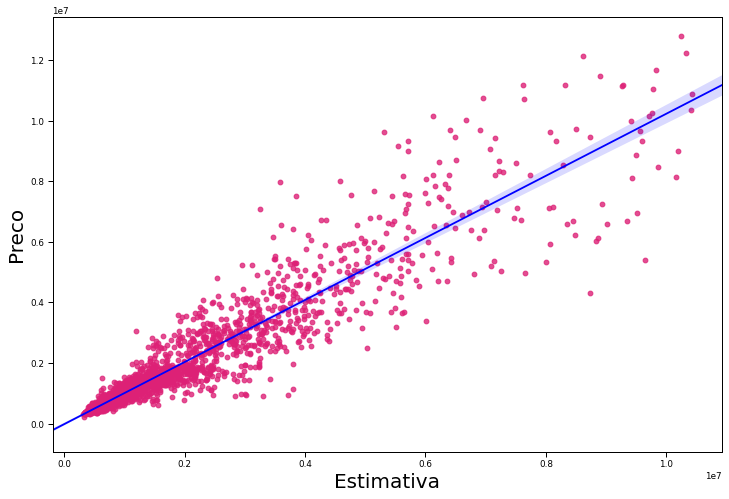

In [188]:
plot_real_estimativa(y_test,modelo3.predict(X_test_scaler_feature))

O modelo 3 apresentou piora em relação ao modelo 2, mesmo testando os mesmos parâmetros do modelo 2. Algum sobreajuste pode ter ocorrido e, para os dados de teste, os resultados não foram tão bons quando comparados com o modelo 2 

# Tentativa de melhoria nas estimativas: utilização de outro modelo

Por mais que nos testes, o modelo ExtraTreeRegressor tenha se saído melhor, podemos realizar outras combinações de parâmetros em outro modelo e obter resultados ainda melhores. Vamos fazer isso com o modelo XGBRFRegressor (o 2º melhor nos testes).

In [46]:
# Vamos utilizar do RandomizedSearchCV para realizar uma nova busca
param_grid4 = {#"tree_method": ['gpu_hist'],
               "max_depth": [30,50,70,90,100,300,500,1000],
               "eta": stats.beta(a = 2, b = 5),
               "gamma": stats.gamma(a = 7.5),
               "alpha": stats.gamma(a = 1.5),
               "lambda":stats.gamma(a = 2)
             }

GD4 = RandomizedSearchCV(cv=8,
                         estimator = XGBRFRegressor(booster= "gbtree", objective = 'reg:squarederror',eval_metric = "rmse"),#,tree_method= 'gpu_hist'),
                         param_distributions = param_grid4,
                         scoring='neg_root_mean_squared_error',
                         n_iter = 500,
                         n_jobs = 4,
                         verbose = 1)    

In [47]:
GD4.fit(X_train_scaler_feature,y_train)

Fitting 8 folds for each of 500 candidates, totalling 4000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  6.5min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 10.1min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 14.7min
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed: 20.0min
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed: 26.2min
[Parallel(n_jobs=4)]: Done 4000 out of 4000 | elapsed: 32.8min finished


RandomizedSearchCV(cv=8,
                   estimator=XGBRFRegressor(base_score=None, booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bytree=None,
                                            eval_metric='rmse', gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_p...
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201143770C8>,
                                        'eta'

In [50]:
#Salvando modelo4
pickle.dump(GD4.best_estimator_,open("modelo4.plk","wb"))

In [48]:
GD4.best_params_

{'alpha': 7.101038008709094,
 'eta': 0.13324325654096694,
 'gamma': 2.842669207361059,
 'lambda': 0.35330383998243575,
 'max_depth': 90}

In [68]:
modelo4 = pickle.load(open('modelo4.plk','rb'))

In [70]:
apresenta_resultados(X_test_scaler_feature,y_test,modelo4)

Este modelo apresentou um RMSE de 724291.4 e R² de 0.86 para os dados de teste


Mesmo otimizando os hiperparâmetros, os resultados do modelo 4 não foram melhores que os obtidos no modelo 2

# Encontrando os preços para a base de oferta

O melhor modelo encontrado foi o modelo 2, que teve um bom resultado de R²: 0.88

Vamos entrar mais no detalhe dos resultados de teste e ver como ele se comportou

In [40]:
comparacao_dados_teste = pd.DataFrame({"Preco":y_test,"Estimativa":modelo2.predict(X_test_scaler_feature)})

In [42]:
#Vamos verificar como se comportou o desvio absoluto percentual para cada amostra de teste
comparacao_dados_teste['Abs_Perc_Erro'] = np.abs(comparacao_dados_teste["Preco"] - comparacao_dados_teste["Estimativa"])/comparacao_dados_teste["Preco"]
comparacao_dados_teste

Preco    Estimativa  Abs_Perc_Erro
5524  3392000  5.808415e+06       0.712386
6211   622476  6.593606e+05       0.059255
6266   534509  5.646256e+05       0.056344
2598  2844346  2.873416e+06       0.010220
5276  5996105  6.560716e+06       0.094163
...       ...           ...            ...
4182  1011825  1.207890e+06       0.193774
945   1790751  2.115299e+06       0.181236
3655  1463936  1.313550e+06       0.102727
2173   622314  6.992194e+05       0.123580
1903  1329979  1.522238e+06       0.144558

[2236 rows x 3 columns]

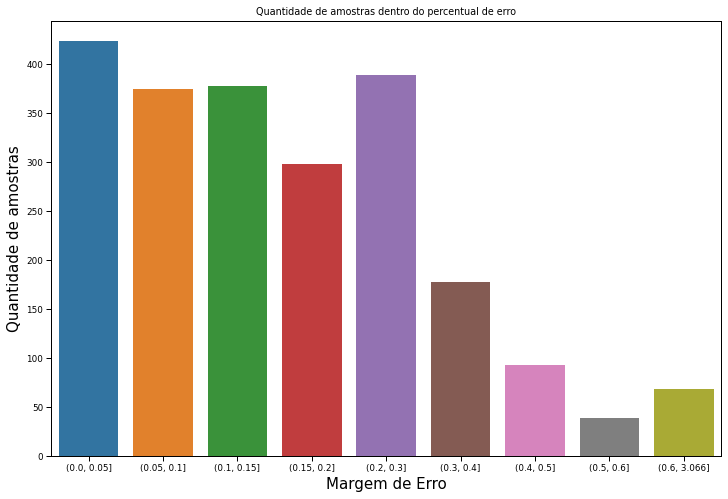

In [48]:
#Vamos dividir os erros absolutos em categorias
comparacao_dados_teste["Margem_erro"] = pd.cut(comparacao_dados_teste.Abs_Perc_Erro,[0,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.6,comparacao_dados_teste.Abs_Perc_Erro.max()])
plt.figure(figsize=(12,8))
sns.countplot(comparacao_dados_teste["Margem_erro"])
plt.title("Quantidade de amostras dentro do percentual de erro")
plt.xlabel("Margem de Erro"),
plt.ylabel("Quantidade de amostras")
plt.show()

In [60]:
#Pelo sumário, percebe-se que 83% das previsões possuem, no máximo, 30% de erro, sendo que a maioria possui no máximo, 15% de erro
sumario_comparacao_teste = comparacao_dados_teste.Margem_erro.value_counts().sort_index().reset_index().rename(columns = {"index":"Margem_erro","Margem_erro":"Quantidade"})
sumario_comparacao_teste["Percentual"] = round(100*sumario_comparacao_teste["Quantidade"]/sumario_comparacao_teste["Quantidade"].sum())
sumario_comparacao_teste["Percentual_Acumulado"] = sumario_comparacao_teste["Percentual"].cumsum()
sumario_comparacao_teste

Margem_erro  Quantidade  Percentual  Percentual_Acumulado
0   (0.0, 0.05]         423        19.0                  19.0
1   (0.05, 0.1]         374        17.0                  36.0
2   (0.1, 0.15]         377        17.0                  53.0
3   (0.15, 0.2]         298        13.0                  66.0
4    (0.2, 0.3]         389        17.0                  83.0
5    (0.3, 0.4]         177         8.0                  91.0
6    (0.4, 0.5]          92         4.0                  95.0
7    (0.5, 0.6]          38         2.0                  97.0
8  (0.6, 3.066]          68         3.0                 100.0

Vamos então aplicar o modelo aos dados novos, mas antes, precisamos converter os dados novos para o formato esperado pelo modelo

In [65]:
#Removendo variáveis não utilizadas por conta da alta correlação
oferta_teste = oferta.drop(columns = var_remover)

#Realizando o encoding de medianas
for chave,valor in dicionario_medianas.items():
     oferta_teste =  pd.merge(oferta_teste,
                             valor.reset_index(),
                             on = chave,
                             how = 'left').drop(columns = chave).rename(columns = {"preco":chave})

#Relizando o encoding ordinal
oferta_teste["metro_estacao"] = encoder.transform(np.array(oferta_teste["metro_estacao"]).reshape(-1,1))

#Realizando a normalização dos dados
oferta_teste_scaler = min_max.transform(oferta_teste)
        
#Realizando o feature selection
colunas_ofertas_manter = [list(oferta_teste.columns).index(var) for var in var_modelagem]

X_ofertas = oferta_teste_scaler[:,colunas_ofertas_manter]

In [66]:
#Carregando o modelo salvo
modelo2 = pickle.load(open("modelo2.plk","rb"))

In [77]:
#Apresentando os resultados
pd.DataFrame({"Preco_Estimado":modelo2.predict(X_ofertas)})["Preco_Estimado"].apply(lambda x: "R$ "+str(round(x,2)) ).reset_index().drop(columns = "index")

Preco_Estimado
0   R$ 2215717.59
1     R$ 343533.0
2   R$ 1080697.59
3   R$ 3364193.93
4    R$ 708636.46
5     R$ 532255.4
6   R$ 3020555.62
7   R$ 5605671.14
8  R$ 10094240.38

# Melhorias na modelagem e próximos passos

O que poderiamos tentar fazer para melhorar o modelo:

* realizar os mesmos testes que fizemos para outros modelos que tiveram resultados promissores, como XGBRegressor e RandomForest;
* poderíamos conversar com a área de negócio e verificar se nossas escolhas pelas variáveis que explicam o preço fazem sentido e se alguma variável que não consideramos poderia ser relevante;
* poderíamos realizar testes com todas as variáveis, sem aplicar feature selection e ver os resultados;
* estressar um pouco mais das possibilidades de melhoria de hiperparâmetros da ETR;
* não fizemos nenhum tratamento de outliers, por conta da distribuição dos preços não normal, mas poderíamos entrar em contato com a área de negócio e apresentar alguns casos extremos e verificar a validade;
* análise geográfica dos preços, visualizando os grupos espacialmente;
* aplicar uma técnica de clusterização, adicionar essa informação à base de dados e realizar a modelagem com ela

Próximos passos:

* Apresentação dos resultados para a área de negócio;
* Validado o modelo, deploy;